In [ ]:

import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz
import os
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.contrib.examples.util  # patches torchvision
from pyro.contrib.examples.util import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from IPython.display import clear_output


# B.1

## Data

In [ ]:
def f(x):
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = f(X)
x = torch.tensor([-1/4])
XNew = torch.linspace(-1, 1, steps=200)

## Gaussian process definition

In [ ]:
def make_gpr(X,y, default = True, kernel = None, prior_dict = None):
    pyro.clear_param_store()
    if default:
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
    else:
        #assert kernel is not None
        assert isinstance(prior_dict, dict)
        for attr,prior in prior_dict.items():
            setattr(kernel, attr, prior)
    return gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10**(-4)))

## MCMC hyper-parameters

In [ ]:
C = 4
W = 10
N = 500
#C = 2
#W = 1
#N = 4

## Sampling posterior of GP with MCMC

In [143]:
def mcmc_sampler(gpr, C, W, N):
    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile = True, ignore_jit_warnings=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=N,
                        num_chains=C, warmup_steps = W)
    mcmc.run()
    return mcmc

In [144]:
gpr = make_gpr(X, y)
mcmc = mcmc_sampler(gpr, C, W, N)

TypeError: MCMC.__init__() got an unexpected keyword argument 'ignore_jit_warnings'

## Estimates of mean and variance based on samples

In [ ]:
def predictive(x, gpr, default = True, prior_dict = None):
    if default:
        gpr.kernel.variance = pyro.nn.module.PyroSample(dist.LogNormal(-1.0, 1.0))
        gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
    else:
        assert isinstance(prior_dict, dict)
        for attr,prior in prior_dict.items():
            setattr(gpr.kernel, attr, prior)
    loc, cov = gpr(x, noiseless = False, full_cov = True)
    var = cov.diag()
    pyro.sample("loc", dist.Delta(loc))
    pyro.sample("var", dist.Delta(var))
    pyro.sample("f", dist.Normal(loc, var))

In [ ]:
def sample_predict(x, gpr, mcmc, default = True, prior_dict = None):
    posterior_samples=mcmc.get_samples(group_by_chain=True)
    posterior_samples_flat = {k : v.flatten() for (k,v) in posterior_samples.items()}
    posterior_predictor = pyro.infer.Predictive(predictive, posterior_samples = posterior_samples_flat)
    posterior_predictive = posterior_predictor(x,gpr, default, prior_dict)
    return posterior_predictive, posterior_samples

In [ ]:
posterior_predictive, posterior_samples = sample_predict(x, gpr, mcmc)
posterior_locs = posterior_predictive['loc']
posterior_vars = posterior_predictive['var']
posterior_lengthscale = posterior_samples['kernel.lengthscale']
posterior_variance = posterior_samples['kernel.variance']

## A scatter plot on log-log scale of N = 500 samples from $P(\theta | \mathcal{D})$

In [ ]:
for c in range(C):
    plt.scatter(posterior_lengthscale[c],posterior_variance[c], label = "chain " + str(c))
plt.xlabel(r"$\sigma_l^2$", fontsize = 15)
plt.ylabel(r"$\sigma_v$", fontsize=15)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

## Sample quality analysis

In [ ]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data, hdi_prob=0.95)
print(summary)
arviz.plot_posterior(data, hdi_prob=0.95)


## Plot visualizing $p(f^* | x^*, \mathcal{D})$

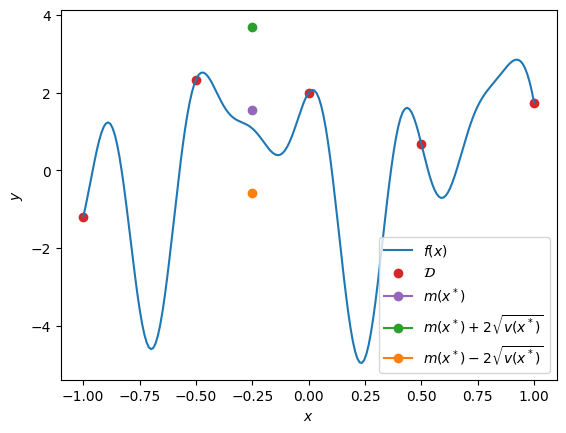

In [31]:
plt.plot(XNew, f(XNew), label = r"$f(x)$")
plt.scatter(X, y, color = 'tab:red', label = r"$\mathcal{D}$")
plt.plot(x, posterior_locs.mean(), color = 'tab:purple', label = r"$m(x^*)$", marker = "o")
plt.plot(x, posterior_locs.mean() + 2*np.sqrt(posterior_vars.mean()), color='tab:green', label=r"$m(x^*) + 2\sqrt{v(x^*)}$", marker="o")
plt.plot(x, posterior_locs.mean() -2*np.sqrt(posterior_vars.mean()), color='tab:orange', label=r"$m(x^*) -2\sqrt{v(x^*)}$", marker="o")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

# B.2

## Algorithm definition

In [ ]:
def algorithm1(X, y, XNew, T, C=C, W=W, N = N, default = True, prior_dict = None):
    X_aug = torch.cat((X, torch.empty(T)))
    y_aug = torch.cat((y, torch.empty(T)))
    X_dim = X.shape[0]
    y_dim = y.shape[0]
    stats = torch.empty((T, 3, XNew.shape[0]))
    minima = torch.empty((T, 2))
    #clear_output(wait=True)
    for k in range(T):
        pyro.clear_param_store()
        print("Iteration " + str(k+1) + "/" + str(T))
        X_k = X_aug[:X_dim + k]
        y_k = y_aug[:y_dim + k]
        gpr = make_gpr(X_k, y_k, default = True)
        mcmc = mcmc_sampler(gpr, C, W, N)
        posterior_predictive, _ = sample_predict(XNew, gpr, mcmc, default, prior_dict)
        fs = posterior_predictive['f'].mean(dim=0)
        ps = torch.argmin(fs)
        X_min = XNew[ps]
        y_min = f(X_min)
        X_aug[X_dim+k] = X_min
        y_aug[y_dim+k] = y_min
        print(posterior_predictive['loc'].mean(dim=0).shape)
        stats[k, 0, :] = posterior_predictive['loc'].mean(dim=0)
        stats[k, 1, :] = posterior_predictive['var'].mean(dim=0)
        stats[k, 2, :] = fs
        minima[k, 0] = X_min
        minima[k, 1] = y_min
    return stats, minima

## Algorithm hyper-parameters

In [33]:
T = 10
C = 1
N = 10
W = 10

## Running the algorithm

In [140]:
stats, minima = algorithm1(X, y, XNew, T, C, W, N)


Iteration 1/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 32.51it/s, step size=3.61e-01, acc. prob=0.858]


torch.Size([200])
Iteration 2/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 34.16it/s, step size=2.91e-01, acc. prob=0.939]


torch.Size([200])
Iteration 3/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 31.66it/s, step size=2.75e-01, acc. prob=0.940]


torch.Size([200])
Iteration 4/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 21.77it/s, step size=8.42e-02, acc. prob=0.997]


torch.Size([200])
Iteration 5/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 29.26it/s, step size=1.98e-01, acc. prob=0.978]


torch.Size([200])
Iteration 6/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 30.53it/s, step size=8.03e-02, acc. prob=0.996]


torch.Size([200])
Iteration 7/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 30.83it/s, step size=2.68e-01, acc. prob=0.829]


torch.Size([200])
Iteration 8/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 24.39it/s, step size=4.70e-02, acc. prob=0.995]


torch.Size([200])
Iteration 9/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 28.80it/s, step size=7.39e-02, acc. prob=0.995]


torch.Size([200])
Iteration 10/10


Warmup:   0%|          | 0/20 [00:00, ?it/s]/home/pants007/.local/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Sample: 100%|██████████| 20/20 [00:00, 32.60it/s, step size=5.92e-03, acc. prob=0.999]

torch.Size([200])


## B.2-1 plotting

In [66]:
stats.shape

torch.Size([10, 3, 200])

### Plot of f and f*

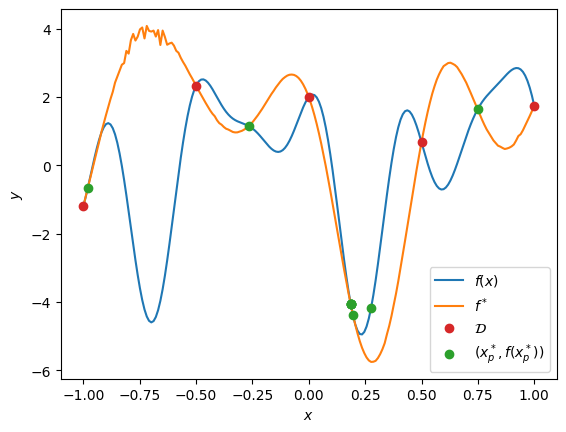

In [141]:
plt.plot(XNew, f(XNew), label = r"$f(x)$")
plt.plot(XNew, stats[9,2,:], label= r"$f^*$")
plt.scatter(X, y, color = 'tab:red', label = r"$\mathcal{D}$", zorder=4)
plt.scatter(minima[:,0], minima[:,1], color = 'tab:green', label = r"$(x^*_p, f(x^*_p))$", zorder=4)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

### Plot of f and confidence intervals

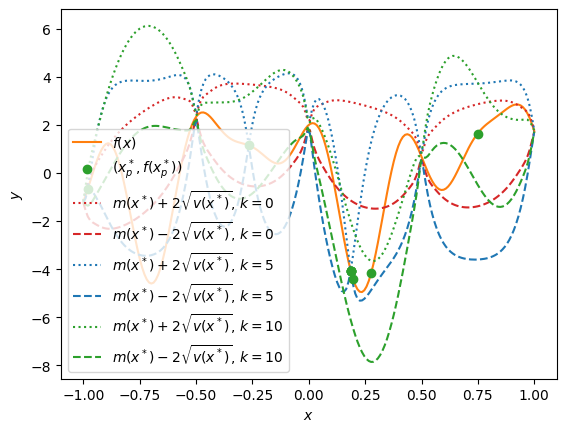

In [142]:
plt.plot(XNew, f(XNew), label = r"$f(x)$", color='tab:orange')
plt.scatter(minima[:,0], minima[:,1], color = 'tab:green', label = r"$(x^*_p, f(x^*_p))$", zorder=4)
plt.plot(XNew, stats[0,0,:] + 2 * np.sqrt(stats[0,1,:]), label=r"$m(x^*) + 2\sqrt{v(x^*)}$, $k=0$", linestyle='dotted', color='tab:red')
plt.plot(XNew, stats[0,0,:] - 2 * np.sqrt(stats[0,1,:]), label=r"$m(x^*) - 2\sqrt{v(x^*)}$, $k=0$", linestyle='dashed', color='tab:red')
plt.plot(XNew, stats[4,0,:] + 2 * np.sqrt(stats[4,1,:]), label=r"$m(x^*) + 2\sqrt{v(x^*)}$, $k=5$", linestyle='dotted', color='tab:blue')
plt.plot(XNew, stats[4,0,:] - 2 * np.sqrt(stats[4,1,:]), label=r"$m(x^*) - 2\sqrt{v(x^*)}$, $k=5$", linestyle='dashed', color='tab:blue')
plt.plot(XNew, stats[9,0,:] + 2 * np.sqrt(stats[0,1,:]), label=r"$m(x^*) + 2\sqrt{v(x^*)}$, $k=10$", linestyle='dotted', color='tab:green')
plt.plot(XNew, stats[9,0,:] - 2 * np.sqrt(stats[0,1,:]), label=r"$m(x^*) - 2\sqrt{v(x^*)}$, $k=10$", linestyle='dashed', color='tab:green')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

## Trying different kernels / grid search of priors

In [ ]:
kernel1 = 